# A Clean Version of the MPC Implementation

### Imports

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"
from keras.models import Model
import gspread
from oauth2client.service_account import ServiceAccountCredentials
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import pickle
import keras
import tensorflow as tf
from keras import backend as K
import sys

import time
sys.path.append(os.path.abspath('../'))
import helpers
from helpers.data_generator import process_data, AutoEncoderDataGenerator, DataGenerator
from helpers.custom_losses import normed_mse, mean_diff_sum_2, max_diff_sum_2, mean_diff2_sum2, max_diff2_sum2, denorm_loss, hinge_mse_loss, percent_correct_sign, baseline_MAE
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from time import strftime, localtime
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import copy
from tqdm import tqdm_notebook
from helpers.normalization import normalize, denormalize, renormalize
import scipy
from keras.utils.vis_utils import model_to_dot
from IPython.display import Image, display
from helpers.custom_init import downsample
from helpers.custom_reg import groupLasso
import helpers
from tqdm import tqdm

Using TensorFlow backend.


573
435
Total: 11061


### Load Files and Model

In [2]:
# # 'model-conv2d_profiles-dens-temp-q_EFIT01-rotation-press_EFIT01_act-target_density-pinj-tinj-curr_target_15Mar20-03-48_Scenario-265_params.pkl'
os.chdir(os.path.expanduser('/projects/EKOLEMEN/profile_predictor/run_results_03_10/'))
files = [foo for foo in os.listdir() if 'Scenario-265.h5' in foo]
print("Matching files at {} are : {}".format(os.getcwd(),files))

Matching files at /projects/EKOLEMEN/profile_predictor/run_results_03_10 are : ['model-conv2d_profiles-dens-temp-q_EFIT01-rotation-press_EFIT01_act-target_density-pinj-tinj-curr_target_15Mar20-03-48_Scenario-265.h5']


In [40]:
# Extract A, B from Autoencoder model

def get_AB(model):
    A = model.get_layer('AB_matrices').get_weights()[1].T
    B = model.get_layer('AB_matrices').get_weights()[0].T
    return A,B
def get_submodels(model):
    from keras.models import Model
    state_encoder = model.get_layer('state_encoder_time_dist').layer.layers[-1]
    control_encoder = model.get_layer('ctrl_encoder_time_dist').layer.layers[-1]
    state_decoder = model.get_layer('state_decoder_time_dist').layer
    return state_encoder, state_decoder, control_encoder

def get_control_decoder_matrices(control_encoder):
    A1 = control_encoder.layers[5].get_weights()[0]
    A2 = control_encoder.layers[6].get_weights()[0]
    B1 = control_encoder.layers[5].get_weights()[1]
    B2 = control_encoder.layers[6].get_weights()[1]
    
    A1 = np.linalg.inv(A1)
    A2 = np.linalg.inv(A2)
    
    return A1, A2, B1, B2

def decode_control(A1, A2, B1, B2, u_enc):
    u_dec = []
    for elem in u_enc:
        u = A2 @ (elem - B2)
        u = A1 @ (u - B1)      
        u_dec.append(u)
    return np.array(u_dec)
        

def get_state_and_inputs(scenario,inputs,**kwargs):
    state_inputs = {}
    x0 = {}
    for sig in scenario['profile_names']+scenario['scalar_names']:
        state_inputs[sig] = np.squeeze(inputs[0]['input_'+sig])
        if sig in scenario['profile_names']:
            x0['input_'+sig] = inputs[0]['input_'+sig][0][0].reshape((1,1,scenario['profile_length']))
        else:
            x0['input_'+sig] = inputs[0]['input_'+sig][0][0].reshape((1,1,1))
    
    control_inputs = {}
    for sig in scenario['actuator_names']:
        control_inputs['input_'+sig] = inputs[0]['input_'+sig]
    return x0, control_inputs, state_inputs

def encode_state_and_inputs(state_encoder,control_encoder,scenario,x0,control_inputs,**kwargs):
    # encode control
    T = scenario['lookahead']
    u = []
    for i in range(T):
        temp_input = {k:v[:,i].reshape((1,1,1)) for k,v in control_inputs.items()}
        u.append(np.squeeze(control_encoder.predict(temp_input)))
        
    # encode state and propogate
    x0 = np.squeeze(state_encoder.predict(x0))
    return x0, u

def encode_state(state_encoder, x0):
    return np.squeeze(state_encoder.predict(x0))

def decode_state(state_decoder,x):
    return state_decoder.predict(x[np.newaxis,:])


def decode_inputs(control_decoder, inputs):
    return control_decoder.predict(inputs)

def get_final_state(state_encoder,scenario,inputs,**kwargs):
    state_inputs = {}
    xf = {}
    for sig in scenario['target_profile_names']+scenario['scalar_names']:
        state_inputs[sig] = np.squeeze(inputs[0]['input_'+sig])
        if sig in scenario['profile_names']:
            xf['input_'+sig] = inputs[0]['input_'+sig][0][3].reshape((1,1,scenario['profile_length']))
        else:
            xf['input_'+sig] = inputs[0]['input_'+sig][0][3].reshape((1,1,1))
    
    xf_enc = np.squeeze(state_encoder.predict(xf))
    return xf, xf_enc

def get_state_predictions(scenario,x_dec):
    state_predictions = {}
    for i, sig in enumerate(scenario['target_profile_names']):
        state_predictions[sig] = np.squeeze(x_dec[0][i*33:(i+1)*33])
#     print("x_dec: {}".format(x_dec))
#     print("state_pred: {}".format(state_predictions))
    return state_predictions

def mean_squared_error(true,pred):
    return np.mean((true-pred)**2)

def mean_absolute_error(true,pred):
    return np.mean(np.abs(true-pred))

def median_absolute_error(true,pred):
    return np.median(np.abs(true-pred))

def percentile25_absolute_error(true,pred):
    return np.percentile(np.abs(true-pred),25)

def percentile75_absolute_error(true,pred):
    return np.percentile(np.abs(true-pred),75)

def median_squared_error(true,pred):
    return np.median((true-pred)**2)

def percentile25_squared_error(true,pred):
    return np.percentile((true-pred)**2,25)

def percentile75_squared_error(true,pred):
    return np.percentile((true-pred)**2,75)

def huber_error(true,pred):
    return np.mean(np.where(np.abs(pred-true) < 0.7, 0.5*(pred - true)**2, 0.7*(np.abs(pred-true)-0.5*0.7)))

In [4]:

################# Models ################################

### Run Results 04_10
# Model 7 (layer scale = 2)
# model_path = '/home/aiqtidar/run_results_04_10/final_model-autoencoder_SET-dense_SDT-dense_CET-dense_CDT-dense_profiles-dens-temp-q_EFIT01-rotation-press_EFIT01_act-target_density-pinj-tinj-curr_target_LB-0_LA-6_10Apr21-18-37_Scenario-7.h5'
# scenario_path = '/home/aiqtidar/run_results_04_10/final_model-autoencoder_SET-dense_SDT-dense_CET-dense_CDT-dense_profiles-dens-temp-q_EFIT01-rotation-press_EFIT01_act-target_density-pinj-tinj-curr_target_LB-0_LA-6_10Apr21-18-37_Scenario-7_params.pkl'

# Model 2 (layer scale = 1)
# model_path = '/home/aiqtidar/run_results_04_10/final_model-autoencoder_SET-dense_SDT-dense_CET-dense_CDT-dense_profiles-dens-temp-q_EFIT01-rotation-press_EFIT01_act-target_density-pinj-tinj-curr_target_LB-0_LA-6_10Apr21-17-25_Scenario-2.h5'
# scenario_path = '/home/aiqtidar/run_results_04_10/final_model-autoencoder_SET-dense_SDT-dense_CET-dense_CDT-dense_profiles-dens-temp-q_EFIT01-rotation-press_EFIT01_act-target_density-pinj-tinj-curr_target_LB-0_LA-6_10Apr21-17-25_Scenario-2_params.pkl'

# Model 2 with lookahead = 4
# model_path = '/home/aiqtidar/run_results_04_12/final_model-autoencoder_SET-dense_SDT-dense_CET-dense_CDT-dense_profiles-dens-temp-q_EFIT01-rotation-press_EFIT01_act-target_density-pinj-tinj-curr_target_LB-0_LA-4_13Apr21-16-43_Scenario-0.h5'
# scenario_path = '/home/aiqtidar/run_results_04_12/final_model-autoencoder_SET-dense_SDT-dense_CET-dense_CDT-dense_profiles-dens-temp-q_EFIT01-rotation-press_EFIT01_act-target_density-pinj-tinj-curr_target_LB-0_LA-4_13Apr21-16-43_Scenario-0_params.pkl'

# Aaron's Best Model
# model_path = '/home/aaronwu/run_results_06_30/model-autoencoder_SET-dense_SDT-dense_CET-dense_CDT-dense_profiles-temp-dens-ffprime_EFIT02-press_EFIT02-q_EFIT02_act-pinj-curr-tinj-gasA_LB-0_LA-3_30Jun20-17-10.h5'
# scenario_path ='/home/aaronwu/run_results_06_30/model-autoencoder_SET-dense_SDT-dense_CET-dense_CDT-dense_profiles-temp-dens-ffprime_EFIT02-press_EFIT02-q_EFIT02_act-pinj-curr-tinj-gasA_LB-0_LA-3_30Jun20-17-10_params.pkl'

# Aaron's Ideal Hyperparam
scenario_path = '/home/aiqtidar/run_results_04_15_Aaron_Best/final_model-autoencoder_SET-dense_SDT-dense_CET-dense_CDT-dense_profiles-dens-temp-q_EFIT01-rotation-press_EFIT01_act-target_density-pinj-tinj-curr_target_LB-0_LA-4_15Apr21-13-36_Scenario-0_params.pkl'
model_path = '/home/aiqtidar/run_results_04_15_Aaron_Best/final_model-autoencoder_SET-dense_SDT-dense_CET-dense_CDT-dense_profiles-dens-temp-q_EFIT01-rotation-press_EFIT01_act-target_density-pinj-tinj-curr_target_LB-0_LA-4_15Apr21-13-36_Scenario-0.h5'


# Load Model
model = keras.models.load_model(model_path, compile=False)
with open(scenario_path, 'rb') as f:
    scenario_auto = pickle.load(f, encoding='latin1')

    
A,B = get_AB(model)
state_encoder, state_decoder, control_encoder = get_submodels(model)
A1_inv, A2_inv, B1, B2 = get_control_decoder_matrices(control_encoder)

print("A: " + str(A.shape))
print("B: " + str(B.shape))

# Ideal Convolutional Model
model = keras.models.load_model('/projects/EKOLEMEN/profile_predictor/run_results_03_10/model-conv2d_profiles-dens-temp-q_EFIT01-rotation-press_EFIT01_act-target_density-pinj-tinj-curr_target_15Mar20-03-48_Scenario-265.h5', compile=False)
with open('/projects/EKOLEMEN/profile_predictor/run_results_03_10/model-conv2d_profiles-dens-temp-q_EFIT01-rotation-press_EFIT01_act-target_density-pinj-tinj-curr_target_15Mar20-03-48_Scenario-265_params.pkl', 'rb') as f:
    scenario = pickle.load(f, encoding='latin1')


W0421 13:21:22.755714 35184372369072 module_wrapper.py:139] From /scratch/gpfs/aiqtidar/.conda/envs/tfgpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0421 13:21:22.795882 35184372369072 module_wrapper.py:139] From /scratch/gpfs/aiqtidar/.conda/envs/tfgpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0421 13:21:23.015533 35184372369072 module_wrapper.py:139] From /scratch/gpfs/aiqtidar/.conda/envs/tfgpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

/scratch/gpfs/aiqtidar/.conda/envs/tfgpu/lib/python3.7/site-packages/keras/engine/saving.py:348: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  war

A: (70, 70)
B: (70, 4)


In [5]:
scenario_auto.keys();

### Prepare Data

In [6]:
# CPU Only. 
os.environ["CUDA_VISIBLE_DEVICES"]="-1"  
num_cores = 1
config = tf.ConfigProto(intra_op_parallelism_threads=4*num_cores,
                        inter_op_parallelism_threads=4*num_cores, 
                        allow_soft_placement=True,
                        device_count = {'CPU' : 1,
                                        'GPU' : 0})
                        
session = tf.Session(config=config)
K.set_session(session)

%matplotlib inline
font={'family': 'DejaVu Serif',
      'size': 18}
plt.rc('font', **font)
matplotlib.rcParams['figure.facecolor'] = (1,1,1,1)

matplotlib_colors = [(0.1215, 0.4667, 0.7058), # blue
                     (1.0000, 0.4980, 0.0549), # orange
                     (0.1725, 0.6275, 0.1725), # green
                     (0.8392, 0.1529, 0.1568), # red
                     (0.5804, 0.4039, 0.7412), # violet
                     (0.4980, 0.4980, 0.4980), # grey
                     (0.0902, 0.7450, 0.8117)] # cyan

matlab_colors=[(0.0000, 0.4470, 0.7410), # blue
               (0.8500, 0.3250, 0.0980), # reddish orange
               (0.9290, 0.6940, 0.1250), # yellow
               (0.4940, 0.1840, 0.5560), # purple
               (0.4660, 0.6740, 0.1880), # light green
               (0.3010, 0.7450, 0.9330), # cyan
               (0.6350, 0.0780, 0.1840)] # dark red

colorblind_colors = [(0.0000, 0.4500, 0.7000), # blue
                     (0.8359, 0.3682, 0.0000), # vermillion
                     (0.0000, 0.6000, 0.5000), # bluish green
                     (0.9500, 0.9000, 0.2500), # yellow
                     (0.3500, 0.7000, 0.9000), # sky blue
                     (0.8000, 0.6000, 0.7000), # reddish purple
                     (0.9000, 0.6000, 0.0000)] # orange

dashes = [(1.0, 0.0, 0.0, 0.0, 0.0, 0.0), # solid
          (3.7, 1.6, 0.0, 0.0, 0.0, 0.0), # dashed
          (1.0, 1.6, 0.0, 0.0, 0.0, 0.0), # dotted
          (6.4, 1.6, 1.0, 1.6, 0.0, 0.0), # dot dash
          (3.0, 1.6, 1.0, 1.6, 1.0, 1.6), # dot dot dash
          (6.0, 4.0, 0.0, 0.0, 0.0, 0.0), # long dash
          (1.0, 1.6, 3.0, 1.6, 3.0, 1.6)] # dash dash dot

from matplotlib import rcParams, cycler
matplotlib.rcdefaults()
rcParams['font.family'] = 'DejaVu Serif'
rcParams['mathtext.fontset'] = 'cm'
rcParams['font.size'] = 12
rcParams['figure.facecolor'] = (1,1,1,1)
rcParams['figure.figsize'] = (16,8)
rcParams['figure.dpi'] = 141
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['axes.labelsize'] =  'large'
rcParams['axes.titlesize'] = 'x-large'
rcParams['lines.linewidth'] = 2.5
rcParams['lines.solid_capstyle'] = 'round'
rcParams['lines.dash_capstyle'] = 'round'
rcParams['lines.dash_joinstyle'] = 'round'
rcParams['xtick.labelsize'] = 'large'
rcParams['ytick.labelsize'] = 'large'
# rcParams['text.usetex']=True
color_cycle = cycler(color=colorblind_colors)
dash_cycle = cycler(dashes=dashes)
rcParams['axes.prop_cycle'] =  color_cycle

labelsize=10
ticksize=8
# for i,c in enumerate(colorblind_colors):
#     plt.plot((i)*np.ones(5),c=c)

eq_sigs = {'temp':'etemp',
         'thomson_temp_EFITRT1':'etemp',
         'thomson_temp_EFITRT2':'etemp',
         'dens':'edens',
         'thomson_dens_EFITRT1':'edens',
         'thomson_dens_EFITRT2':'edens',
         'itemp':'itemp',
         'cerquick_temp_EFITRT1':'itemp',
         'cerquick_temp_EFITRT2':'itemp',
         'rotation':'rotation',
         'cerquick_rotation_EFITRT1':'rotation',
         'cerquick_rotation_EFITRT2':'rotation',
         'press_EFITRT1':'press',
         'press_EFITRT2':'press',
         'press_EFIT01':'press',
         'press_EFIT02':'press',
         'ffprime_EFITRT1':'ffprime',
         'ffprime_EFITRT2':'ffprime',
         'ffprime_EFIT01':'ffprime',
         'ffprime_EFIT02':'ffprime',
         'q':'q',
         'q_EFITRT1':'q',
         'q_EFITRT2':'q',
         'q_EFIT01':'q',
         'q_EFIT02':'q'}

labels = {'edens': '$n_e$ ($10^{19}/m^3$)',
          'etemp': '$T_e$ (keV)',
          'itemp': '$T_i$ (keV)',
          'rotation':'$\Omega$ (kHz)',
          'q':'$\iota$',
          'press':'$P$ (Pa)',
         'ffprime':"$FF'$"}

labels = {key:labels[val] for key, val in eq_sigs.items()}

scatter_titles = {'mean':'Mean',
                  'std':'Std Dev.',
                  'pca_1':'PCA Mode 1',
                  'pca_2':'PCA Mode 2',
                  'pca_3':'PCA Mode 3',
                  'pca_4':'PCA Mode 4',
                  'pca_5':'PCA Mode 5',
                  'pca_6':'PCA Mode 6',
                  'pca_2':'PCA Mode 2'}


orig_data_path = '/scratch/gpfs/jabbate/full_data_with_error/train_data.pkl'
test_data_path = '/scratch/gpfs/jabbate/full_data_with_error/test_data.pkl' 
traindata, valdata, normalization_dict = helpers.data_generator.process_data(orig_data_path,
                                                      scenario['sig_names'],
                                                      scenario['normalization_method'],
                                                      scenario['window_length'],
                                                      scenario['window_overlap'],
                                                      scenario['lookbacks'],
                                                      scenario['lookahead'],
                                                      scenario['sample_step'],
                                                      scenario['uniform_normalization'],
                                                      1, #scenario['train_frac'],
                                                      0, #scenario['val_frac'],
                                                      scenario['nshots'],
                                                      2, #scenario['verbose']
                                                      scenario['flattop_only'],
                                                      randomize=False,
                                                      pruning_functions=scenario['pruning_functions'],
                                                      excluded_shots = scenario['excluded_shots'],
                                                      delta_sigs = [],
                                                      invert_q=scenario.setdefault('invert_q',False),
                                                      val_idx = 0,
                                                      uncertainties=True)
traindata = helpers.normalization.renormalize(helpers.normalization.denormalize(traindata.copy(),normalization_dict),scenario['normalization_dict'])
valdata = helpers.normalization.renormalize(helpers.normalization.denormalize(valdata.copy(),normalization_dict),scenario['normalization_dict'])

data_generator_batch = DataGenerator(valdata,
                                128, #scenario['batch_size'],
                                scenario['input_profile_names'],
                                scenario['actuator_names'],
                                scenario['target_profile_names'],
                                scenario['scalar_input_names'],
                                scenario['lookbacks'],
                                scenario['lookahead'],
                                scenario['predict_deltas'],
                                scenario['profile_downsample'],
                                shuffle=False,
                                sample_weights = None)

Loading
Signals: curr_target, dens, density_estimate, kappa_EFIT01, li_EFIT01, pinj, press_EFIT01, q_EFIT01, rotation, target_density, temp, tinj, triangularity_bot_EFIT01, triangularity_top_EFIT01, volume_EFIT01
Number of useable shots:  5551
Number of shots used:  5551
Total number of timesteps:  582795
Shots with Complete NaN: 
394389 samples total
Removing ECH
Removed 167477 samples
226912 samples remaining
Removing timesteps WITHOUT gas feedback
Removed 43708 samples
183204 samples remaining
Removing weird I-coils
Removed 40583 samples
142621 samples remaining
Removing NaN
Removed 0 samples
142621 samples remaining
Removing dudtrip
Removed 8101 samples
134520 samples remaining
134520 samples remaining after pruning


Denormalizing:  22%|##2       | 6/27 [00:00<00:00, 59.61it/s]

Total number of samples:  134520
Number of training samples:  121324
Number of validation samples:  13196


Normalizing: 100%|##########| 27/27 [00:00<00:00, 124.04it/s]


In [7]:
data_generator_batch[1][0]['input_past_tinj'];

### Define Encoders and Decoders

In [8]:
model = keras.models.load_model('/projects/EKOLEMEN/profile_predictor/run_results_03_10/model-conv2d_profiles-dens-temp-q_EFIT01-rotation-press_EFIT01_act-target_density-pinj-tinj-curr_target_15Mar20-03-48_Scenario-265.h5', compile=False)
with open('/projects/EKOLEMEN/profile_predictor/run_results_03_10/model-conv2d_profiles-dens-temp-q_EFIT01-rotation-press_EFIT01_act-target_density-pinj-tinj-curr_target_15Mar20-03-48_Scenario-265_params.pkl', 'rb') as f:
    scenario = pickle.load(f, encoding='latin1')


/scratch/gpfs/aiqtidar/.conda/envs/tfgpu/lib/python3.7/site-packages/keras/engine/saving.py:348: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [9]:
# Make Predictions
predictions_arr = np.array(model.predict_generator(data_generator_batch,verbose=1))

104/104 [==============================] - 28s 270ms/step


In [10]:
predictions = {sig: arr for sig, arr in zip(scenario['target_profile_names'],predictions_arr)}

In [11]:
### Use model.predict to get a prediction

def predict_model(i, umpc = None):
    inp = []

    for sig in scenario['target_profile_names']:
        inp.append((data_generator_batch[int(i/128)][0]['input_' + sig][int(i % 128)].reshape((1,1,scenario['profile_length']))))

    for sig in scenario['actuator_names']:
        inp.append((np.array(([np.transpose(data_generator_batch[int(i/128)][0]['input_past_' + sig][int(i % 128)])]))))

    for sig in scenario['actuator_names']:
        if umpc is not None:
            inp.append(umpc)
        else:
            inp.append(np.array(([np.transpose(data_generator_batch[int(i/128)][0]['input_future_' + sig][int(i % 128)])])))

    for sig in scenario['scalar_input_names']:
        inp.append((data_generator_batch[int(i/128)][0]['input_' + sig][int(i % 128)].reshape((1,7))))
    return np.array(model.predict(inp))

In [13]:
with open('/projects/EKOLEMEN/profile_predictor/run_results_03_10/model-conv2d_profiles-dens-temp-q_EFIT01-rotation-press_EFIT01_act-target_density-pinj-tinj-curr_target_15Mar20-03-48_Scenario-265_params.pkl', 'rb') as f:
    scenario = pickle.load(f, encoding='latin1')

In [14]:
scenario['target_profile_names']

['dens', 'temp', 'q_EFIT01', 'rotation', 'press_EFIT01']

In [15]:
scenario['actuator_names']

['target_density', 'pinj', 'tinj', 'curr_target']

In [16]:
scenario['lookahead']

4

In [17]:
model = keras.models.load_model(model_path, compile=False)
A,B = get_AB(model)
state_encoder, state_decoder, control_encoder = get_submodels(model)

model = keras.models.load_model('/projects/EKOLEMEN/profile_predictor/run_results_03_10/model-conv2d_profiles-dens-temp-q_EFIT01-rotation-press_EFIT01_act-target_density-pinj-tinj-curr_target_15Mar20-03-48_Scenario-265.h5', compile=False)

### Finalize Data

In [18]:
###################### Get inital state and actuator inputs ready ######################
X_F_conv_tot = [] # Final state predicted by conv model
X_F_real_tot = [] # Final real state
X_F_enc_tot = [] # Final real state encoded
X_0_tot = [] # Initial state
u_tot = [] # control inputs
X_0_enc_tot = [] # Initial state encoded
u_enc_tot = [] # Encoded control inputs
state_inputs_arr = [] # Contains profiles, for both initial and final state

for i in range(0, predictions_arr.shape[1]):
    print("Completed {} of {}".format(i,predictions_arr.shape[1]),end='\r')
    
    # Get initial profile array
    x0 = {}
    state_inputs = {}
    for sig in scenario['target_profile_names']:
        x0['input_' + sig] = data_generator_batch[int(i/128)][0]['input_' + sig][int(i % 128)].reshape((1,1,scenario['profile_length']))
        xf_real = data_generator_batch[int(i/128)][1]['target_' + sig][int(i % 128)].reshape((1,1,scenario['profile_length']))
        state_inputs['input_' + sig] = np.array([x0['input_' + sig], xf_real])
        
    for sig in scenario['scalar_input_names']:
        x0['input_' + sig] = data_generator_batch[int(i/128)][0]['input_' + sig][int(i % 128)][0].reshape((1,1,1))
    
    # Get control inputs array
    control_inputs = {}
    for sig in scenario['actuator_names']:
        control_inputs['input_'+sig] = np.array(([np.transpose(data_generator_batch[int(i/128)][0]['input_future_' + sig][int(i % 128)] [np.newaxis])]))
    
    # Get target state
    X_F = {}
    X_F_real = {}
    for profile in scenario['target_profile_names']:
        X_F['input_' + profile] = np.array([[predictions[profile][i]]])
        X_F_real['input_' + profile] = state_inputs['input_' + profile][-1]

    for sig in scenario['scalar_input_names']:
        X_F_real['input_' + sig] = data_generator_batch[int(i/128)][0]['input_' + sig][int(i % 128)][-1].reshape((1,1,1))
    
    
    
#     print("x0: {}".format(x0.keys()))
#     print("u: {}".format(control_inputs['input_target_density'].shape))
#     print("u: {}".format(control_inputs['input_target_density']))
    
    x_enc, u_enc = encode_state_and_inputs(state_encoder,control_encoder,scenario,x0,control_inputs)
    
    X_F_real_tot.append(X_F_real)
    X_F_enc_tot.append(encode_state(state_encoder, X_F_real))
    X_F_conv_tot.append(X_F)
    X_0_tot.append(x0)
    u_tot.append(control_inputs)    
    X_0_enc_tot.append(x_enc)
    u_enc_tot.append(u_enc)
    state_inputs_arr.append(state_inputs)
    

In [19]:
# Convert to Numpy Arrays
X_F_real_tot = np.array(X_F_real_tot)
X_F_enc_tot = np.array(X_F_enc_tot)
X_F_conv_tot = np.array(X_F_conv_tot)
X_0_tot = np.array(X_0_tot)
u_tot = np.array(u_tot)
X_0_enc_tot = np.array(X_0_enc_tot)
u_enc_tot = np.array(u_enc_tot)

# print("X_F_tot.shape: {}".format(X_F_tot.shape))
print("X_0_tot.shape: {}".format(X_0_tot.shape))
print("u_tot.shape: {}".format(u_tot.shape))
print("X0_enc_tot.shape: {}".format(X_0_enc_tot.shape))
print("u_enc_tot.shape: {}".format(u_enc_tot.shape))

X_0_tot.shape: (13196,)
u_tot.shape: (13196,)
X0_enc_tot.shape: (13196, 70)
u_enc_tot.shape: (13196, 4, 4)


In [20]:
state_inputs['input_dens'][-1];

In [21]:
# Control decoder example
A1_inv, A2_inv, B1, B2 = get_control_decoder_matrices(control_encoder)
u_dec = decode_control(A1_inv, A2_inv, B1, B2, u_enc_tot[0]);
# u_dec
helpers.normalization.denormalize_arr(u_dec,scenario_auto['normalization_dict'][profile])

array([[ 59001.957 ,   8959.81  , -20656.883 , -63998.492 ],
       [ 52957.02  ,  13185.536 , -13149.328 , -50163.094 ],
       [ 31740.146 ,  28099.922 ,  12073.763 , -14642.297 ],
       [ 22368.203 ,  36455.727 ,  24478.877 ,   4782.4375]],
      dtype=float32)

In [22]:
u_tot[0]

{'input_target_density': array([[[-0.51913744],
         [-0.42296273],
         [-0.3267881 ],
         [-0.23061335]]], dtype=float32),
 'input_pinj': array([[[0.7848003 ],
         [0.64431113],
         [0.2301327 ],
         [0.05321147]]], dtype=float32),
 'input_tinj': array([[[0.8612333 ],
         [0.7304757 ],
         [0.40844566],
         [0.22243078]]], dtype=float32),
 'input_curr_target': array([[[-0.98497546],
         [-0.94506186],
         [-0.90514845],
         [-0.865235  ]]], dtype=float32)}

In [23]:
tempu = {}
for key in scenario['actuator_names']:
    tempu[key] = helpers.normalization.denormalize_arr(u_tot[0]['input_' + key],scenario['normalization_dict'][profile])
# helpers.normalization.normalize(tempu,scenario_auto['normalization_dict'][profile])
    helpers.normalization.normalize_arr(tempu[key],scenario_auto['normalization_dict'][profile][key],uniform_over_profile=True)
tempu

KeyError: 'target_density'

In [ ]:
scenario_auto['normalization_dict'];

In [ ]:
scenario['target_profile_names']

## Manually Propagate SSS

### Use the True Future Control Inputs

N: 70
M: 4
     pcost       dcost       gap    pres   dres
 0: -3.1633e+02 -3.9578e+02  8e+01  6e-17  2e-16
 1: -3.1633e+02 -3.1713e+02  8e-01  1e-16  2e-16
 2: -3.1633e+02 -3.1634e+02  8e-03  2e-16  2e-16
 3: -3.1633e+02 -3.1633e+02  8e-05  2e-16  2e-16
Optimal solution found.


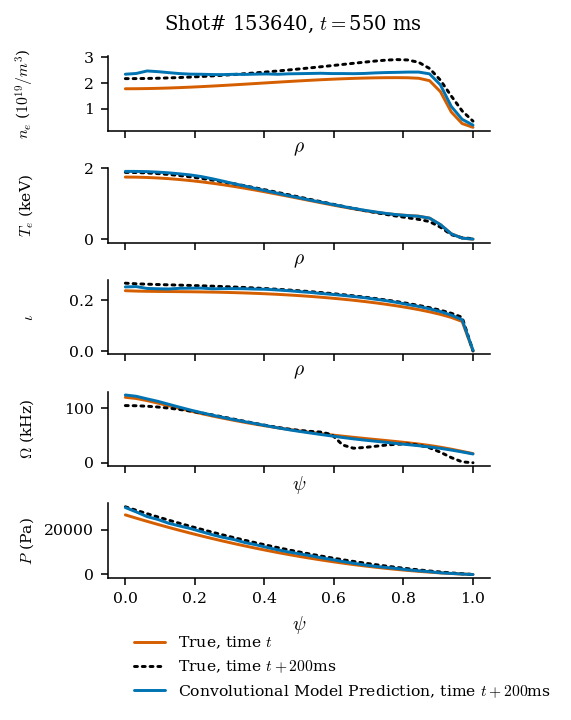

In [31]:
def get_model_prediction(x0, control_inputs, u_mpc, A, B, n):
    state_pred_arr = []
    mpc_pred_arr = []
    x_mpc = x0
    # Propagate through model
    for i in range(0, n):
        if (control_inputs is not None):
            x0 = (x0 @ A.T  + control_inputs[i] @ B.T)
            state_pred_arr.append(get_state_predictions(scenario,decode_state(state_decoder,x0)))
        if (u_mpc is not None):
            x_mpc = (x_mpc @ A.T  + u_mpc[i] @ B.T)
            mpc_pred_arr.append(get_state_predictions(scenario,decode_state(state_decoder,x_mpc)))

    # print("State_predictions: {}".format(state_predictions))
    return state_pred_arr, mpc_pred_arr

# Plotting
def generate_profile_plots(state_predictions, mpc_predictions, conv_predictions, state_inputs, profiles, filtered = False, mpc_filtered = False, conv_filtered = False):
    shotnum = data_generator_batch.cur_shotnum[0,0]
    shottime = data_generator_batch.cur_times[0,-scenario['lookahead']-1]
    psi = np.linspace(0,1,scenario['profile_length'])

    fig, axes = plt.subplots(len(profiles),1,sharex=True, figsize=(3.5,5))
    for j, profile in enumerate(profiles):
        ax = axes[j]

        inp_norm = state_inputs['input_' + profile][0].squeeze()
        true_norm = inp_norm + state_inputs['input_' + profile][-1].squeeze()
        
        inp = helpers.normalization.denormalize_arr(inp_norm,scenario['normalization_dict'][profile])
        true = helpers.normalization.denormalize_arr(true_norm,scenario['normalization_dict'][profile])
        
        ax.plot(psi,inp,lw=1.5,label='True, time $t$',c=colorblind_colors[1])
        ax.plot(psi,true,lw=1.5,label='True, time $t+200$ms',c='k',ls=':')
        
        if (state_predictions is not None):
            if (filtered == True):
                pred = butter_lowpass_filtfilt(state_predictions['input_' + profile].squeeze(), cutoff, fs)
            else:
                pred = (state_predictions[profile].squeeze())
            pred = helpers.normalization.denormalize_arr(pred,scenario_auto['normalization_dict'][profile])
            ax.plot(psi,pred,lw=1.5,label='Autoencoder Prediction, time $t+200$ms',c=colorblind_colors[0])
        
        if (mpc_predictions is not None):
            if (mpc_filtered == True):
                mpc_pred = butter_lowpass_filtfilt(mpc_predictions[profile].squeeze(), cutoff, fs)
            else:
                mpc_pred = (mpc_predictions[profile].squeeze())
            mpc_pred = helpers.normalization.denormalize_arr(mpc_pred,scenario_auto['normalization_dict'][profile])
            ax.plot(psi,mpc_pred,lw=1.5,label='MPC Prediction, time $t+200$ms',c=colorblind_colors[2])
        
        if (conv_predictions is not None):
            if (conv_filtered == True):
                conv_pred = butter_lowpass_filtfilt(conv_predictions[profile].squeeze(), cutoff, fs)
            else:
                conv_pred = inp_norm + (conv_predictions[profile].squeeze())
            conv_pred = helpers.normalization.denormalize_arr(conv_pred,scenario['normalization_dict'][profile])
            ax.plot(psi,conv_pred,lw=1.5,label='Convolutional Model Prediction, time $t+200$ms',c=colorblind_colors[0])


        ax.set_ylabel(labels[profile],size=8)
        ax.tick_params(axis='both', which='major', labelsize=8)

        if j in [0,1,2]:
            ax.set_xlabel('$\\rho$',size=10)
        if j in [3,4]:
            ax.set_xlabel('$\psi$',size=10)
    fig.align_ylabels(axes)
    plt.subplots_adjust(top=.92, bottom=.18, hspace=0.5)
    fig.suptitle("Shot# {}, $t=${} ms".format(int(shotnum), int(shottime)),fontsize=10)
    fig.legend(handles=axes[0].lines,     
               labels=[line._label for line in axes[0].lines],  
               loc="upper center",
               bbox_to_anchor=(0.6, 0.12),
               frameon=False,
               mode=None,
               ncol=1,
              fontsize=8)

### Set up system

index = 55
n = scenario['lookahead']
profiles = scenario['target_profile_names']
temp_x = X_0_enc_tot[index]
temp_u = u_enc_tot[index]
temp_xf = X_F_enc_tot[index]

### Build Conv Model Predictions
conv_pred_profiles = {}
for sig in scenario['target_profile_names']:
    conv_pred_profiles[sig] = predictions[sig][index]
# conv_pred_profiles = None
    
#### Get MPC Solution

N = temp_x.shape[0]
M = u_enc_tot.shape[2]

# Generate Q,R
Q = np.eye(N)*1e-5
R = np.eye(M)*1e3

sol_mpc = solve_Neo_MPC_system(Q,R,A,B,temp_x,temp_xf,n)
sol_mpc = np.array(sol_mpc['x'])
u_mpc = sol_mpc.reshape(n, M)
temp_u_mpc = u_mpc

# mpc_pred = None

#### Call functions to generate plots

state_pred, mpc_pred = get_model_prediction(temp_x, temp_u, temp_u_mpc, A, B, n)
# generate_profile_plots(state_pred[n-1], mpc_pred[-1], conv_pred_profiles, state_inputs_arr[index], profiles, filtered = False)
generate_profile_plots(None, None, conv_pred_profiles, state_inputs_arr[index], profiles, filtered = False)

### Use the MPC Control Inputs

In [36]:
def get_model_prediction(x0, control_inputs, u_mpc, A, B, n):
    state_pred_arr = []
    mpc_pred_arr = []
    x_mpc = x0
    # Propagate through model
    for i in range(0, n):
        if (control_inputs is not None):
            x0 = (x0 @ A.T  + control_inputs[i] @ B.T)
            state_pred_arr.append(get_state_predictions(scenario,decode_state(state_decoder,x0)))
        if (u_mpc is not None):
            x_mpc = (x_mpc @ A.T  + u_mpc[i] @ B.T)
            mpc_pred_arr.append(get_state_predictions(scenario,decode_state(state_decoder,x_mpc)))

    # print("State_predictions: {}".format(state_predictions))
    return state_pred_arr, mpc_pred_arr

# Plotting
def generate_profile_plots(state_predictions, mpc_predictions, conv_predictions, state_inputs, profiles, filtered = False, mpc_filtered = False, conv_filtered = False):
    shotnum = data_generator_batch.cur_shotnum[0,0]
    shottime = data_generator_batch.cur_times[0,-scenario['lookahead']-1]
    psi = np.linspace(0,1,scenario['profile_length'])

    fig, axes = plt.subplots(len(profiles),1,sharex=True, figsize=(3.5,5))
    for j, profile in enumerate(profiles):
        ax = axes[j]

        inp_norm = state_inputs['input_' + profile][0].squeeze()
        true_norm = inp_norm + state_inputs['input_' + profile][-1].squeeze()
        
        inp = helpers.normalization.denormalize_arr(inp_norm,scenario['normalization_dict'][profile])
        true = helpers.normalization.denormalize_arr(true_norm,scenario['normalization_dict'][profile])
        
        ax.plot(psi,inp,lw=1.5,label='True, time $t$',c=colorblind_colors[1])
        ax.plot(psi,true,lw=1.5,label='True, time $t+200$ms',c='k',ls=':')
        
        if (state_predictions is not None):
            if (filtered == True):
                pred = butter_lowpass_filtfilt(state_predictions['input_' + profile].squeeze(), cutoff, fs)
            else:
                pred = (state_predictions[profile].squeeze())
            pred = helpers.normalization.denormalize_arr(pred,scenario_auto['normalization_dict'][profile])
            ax.plot(psi,pred,lw=1.5,label='Autoencoder Prediction, time $t+200$ms',c=colorblind_colors[0])
        
        if (mpc_predictions is not None):
            if (mpc_filtered == True):
                mpc_pred = butter_lowpass_filtfilt(mpc_predictions[profile].squeeze(), cutoff, fs)
            else:
                mpc_pred = (mpc_predictions[profile].squeeze())
            mpc_pred = helpers.normalization.denormalize_arr(mpc_pred,scenario_auto['normalization_dict'][profile])
            ax.plot(psi,mpc_pred,lw=1.5,label='MPC Prediction, time $t+200$ms',c=colorblind_colors[2])
        
        if (conv_predictions is not None):
            if (conv_filtered == True):
                conv_pred = butter_lowpass_filtfilt(conv_predictions[profile].squeeze(), cutoff, fs)
            else:
                conv_pred = inp_norm + (conv_predictions[profile].squeeze())
            conv_pred = helpers.normalization.denormalize_arr(conv_pred,scenario['normalization_dict'][profile])
            ax.plot(psi,conv_pred,lw=1.5,label='Convolutional Model Prediction with MPC Inputs, time $t+200$ms',c=colorblind_colors[0])


        ax.set_ylabel(labels[profile],size=8)
        ax.tick_params(axis='both', which='major', labelsize=8)

        if j in [0,1,2]:
            ax.set_xlabel('$\\rho$',size=10)
        if j in [3,4]:
            ax.set_xlabel('$\psi$',size=10)
    fig.align_ylabels(axes)
    plt.subplots_adjust(top=.92, bottom=.18, hspace=0.5)
    fig.suptitle("Shot# {}, $t=${} ms".format(int(shotnum), int(shottime)),fontsize=10)
    fig.legend(handles=axes[0].lines,     
               labels=[line._label for line in axes[0].lines],  
               loc="upper center",
               bbox_to_anchor=(0.6, 0.12),
               frameon=False,
               mode=None,
               ncol=1,
              fontsize=8)

def gen_conv(index, plot = False):
    ### Set up system
    n = scenario['lookahead']
    profiles = scenario['target_profile_names']
    temp_x = X_0_enc_tot[index]
    temp_u = u_enc_tot[index]
    temp_xf = X_F_enc_tot[index]


    #### Get MPC Solution

    N = temp_x.shape[0]
    M = u_enc_tot.shape[2]

    # Generate Q,R
    Q_scale = 1e5
    R_scale = 1e-10
    
    Q = np.eye(N)
    R = np.eye(M)
    Q = np.eye(N)*Q_scale
    R = np.eye(M)*R_scale

    n_prime = n+20

    sol_mpc = solve_Neo_MPC_system(Q,R,A,B,temp_x,temp_xf,n_prime, lim = 20)
    sol_mpc = np.array(sol_mpc['x'])
    u_mpc = sol_mpc.reshape(n_prime, M)
    temp_u_mpc = u_mpc

#     mpc_pred = None

    ### Build Conv Model Predictions
    conv_pred_profiles = {}
    for i, sig in enumerate(scenario['target_profile_names']):
        conv_pred_profiles[sig] = np.squeeze(predict_model(i, umpc = None)[i])
    # conv_pred_profiles = None

    #### Call functions to generate plots

    state_pred, mpc_pred = get_model_prediction(temp_x, temp_u, temp_u_mpc, A, B, n)
    # generate_profile_plots(state_pred[n-1], mpc_pred[-1], conv_pred_profiles, state_inputs_arr[index], profiles, filtered = False)
    if plot == True:
        generate_profile_plots(None, None, conv_pred_profiles, state_inputs_arr[index], profiles, filtered = False)
    return state_pred, mpc_pred, conv_pred_profiles


N: 70
M: 4
     pcost       dcost       gap    pres   dres
 0: -8.8270e+03 -6.1300e+04  5e+04  5e-17  4e-16
 1: -9.4233e+03 -1.3240e+04  4e+03  2e-16  6e-16
 2: -9.5582e+03 -9.9144e+03  4e+02  2e-16  7e-16
 3: -9.5808e+03 -9.6120e+03  3e+01  2e-16  8e-16
 4: -9.5849e+03 -9.5873e+03  2e+00  2e-16  9e-16
 5: -9.5854e+03 -9.5855e+03  7e-02  2e-16  1e-15
 6: -9.5855e+03 -9.5855e+03  8e-04  2e-16  7e-16
Optimal solution found.


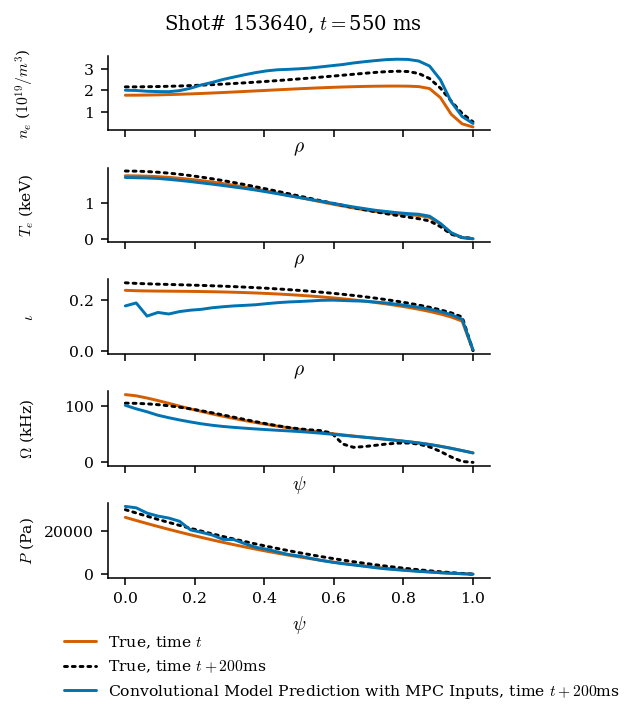

In [39]:
state_pred, mpc_pred, conv_pred_profiles = gen_conv(55, True)

### Generate Statistics

In [50]:
stats_conv_mpc_tot = []

for i in range(0, 1): #len(X_0_tot)
    state_pred, mpc_pred, conv_pred_profiles = gen_conv(i, False)
    stats_conv_mpc = {}
    mse = {}
    mae = {}
    meae = {}
    p25ae = {}
    
    for j, profile in enumerate(scenario['target_profile_names']):
        # True profile
        true_norm = state_inputs_arr[i]['input_' + profile][0].squeeze() + state_inputs_arr[i]['input_' + profile][-1].squeeze()
        true = helpers.normalization.denormalize_arr(true_norm,scenario['normalization_dict'][profile])

        # Convolutional Model Predictions
        conv_pred = state_inputs_arr[i]['input_' + profile][0].squeeze()  + (conv_pred_profiles[profile].squeeze())
        conv_pred = helpers.normalization.denormalize_arr(conv_pred,scenario['normalization_dict'][profile])

        mse_val = mean_squared_error(true,conv_pred)
        mae_val = mean_absolute_error(true,conv_pred)
        meae_val = median_absolute_error(true,conv_pred)
        p25ae_val = percentile25_absolute_error(true,conv_pred)
        
        
        mse[profile] = mse_val
        mae[profile] = mae_val
        meae[profile] = meae_val
        p25ae[profile] = p25ae_val        

    stats_conv_mpc['mse'] = mse
    stats_conv_mpc['mae'] = mae
    stats_conv_mpc['meae'] = meae
    stats_conv_mpc['p25ae'] = p25ae
    
    stats_conv_mpc_tot.append(stats_conv_mpc)
            
            
    

N: 70
M: 4
     pcost       dcost       gap    pres   dres
 0: -5.5150e+03 -4.8708e+04  4e+04  5e-17  4e-16
 1: -6.1959e+03 -9.4354e+03  3e+03  2e-16  8e-16
 2: -6.3087e+03 -6.5832e+03  3e+02  2e-16  1e-15
 3: -6.3229e+03 -6.3461e+03  2e+01  2e-16  9e-16
 4: -6.3256e+03 -6.3279e+03  2e+00  2e-16  9e-16
 5: -6.3261e+03 -6.3262e+03  6e-02  2e-16  8e-16
 6: -6.3261e+03 -6.3261e+03  8e-04  2e-16  8e-16
Optimal solution found.


In [51]:
stats_conv_mpc_tot

[{'mse': {'dens': 0.06554171,
   'temp': 0.029075481,
   'q_EFIT01': 0.000273052,
   'rotation': 1547.4856,
   'press_EFIT01': 107498000.0},
  'mae': {'dens': 0.18239698,
   'temp': 0.13905935,
   'q_EFIT01': 0.0070186737,
   'rotation': 32.811306,
   'press_EFIT01': 7034.316},
  'meae': {'dens': 0.104938984,
   'temp': 0.13399422,
   'q_EFIT01': 0.0025795698,
   'rotation': 25.352295,
   'press_EFIT01': 2950.3281},
  'p25ae': {'dens': 0.04815411567687988,
   'temp': 0.05227184295654297,
   'q_EFIT01': 0.0018191635608673096,
   'rotation': 15.531463623046875,
   'press_EFIT01': 1124.248046875}}]

mae/mean for each profile; low error and large changes;

## Neo MPC System

In [24]:
def lqr(A: np.ndarray, B: np.ndarray, Q: np.ndarray, R: np.ndarray) -> np.ndarray:
    from scipy.linalg import solve_discrete_are
    return solve_discrete_are(A, B, Q, R) 

def solve_Neo_MPC_system(Q,R,A,B,x0,xf,n, lim = 2):
    
    # Imports
    import numpy
    from cvxopt import matrix
    from cvxopt import solvers
    
    # Define parameters
    N = A.shape[0]
    M = B.shape[1]
    print("N: {}".format(N))
    print("M: {}".format(M))
    
    # Reshape to avoid complications
    x0 = x0.reshape((N,1))
    xf = xf.reshape((N,1))

    ############################### Generate Matrices ####################################

    # Generate Matrix M
    M_bar = np.zeros((N * n, N))
    rsl = slice(0, N)
    M_bar[rsl, :N] = A

    for i in range(1, n):
        rsl_p, rsl = rsl, slice(i * N, (i + 1) * N)
        M_bar[rsl, :N] = A @ M_bar[rsl_p, :N]
    
#     print("M_bar: {}".format(M_bar))
    
    # Generate Q_bar
    Q_bar = np.zeros((N * n, N * n))
    rsl = slice(0, N)
    Q_bar[rsl, :N] = Q

    for i in range(1, n-1):
        rsl_p, rsl = rsl, slice(i * N, (i + 1) * N)
        Q_bar[rsl, N : (i + 1) * N] = Q_bar[rsl_p, : i * N]
    
    Q_N = lqr(A,B,Q,R)
    rsl = slice((n-1) * N, n * N)
    Q_bar[rsl, rsl] = Q_N
    
#     print("Q_bar: {}".format(Q_bar))

    # Generate R_bar
    R_bar = np.kron(np.eye(n),R)
    
#     print("R_bar: {}".format(R_bar))

    # Generate V
    V = np.zeros((N * n, n * M))
    rsl = slice(0, N)
    V[rsl, :M] = B #Make first line

    for i in range(1, n):
        rsl_p, rsl = rsl, slice(i * N, (i + 1) * N)
        V[rsl, :M] = A @ V[rsl_p, :M] # A^(N-1)*B
        V[rsl, M : (i + 1) * M] = V[rsl_p, : i * M]
    
#     print("V: {}".format(V))
        
    # Generate L
    L = np.zeros((N * n, N * n))
    rsl = slice(0, N)
    L[rsl, :N] = A #Make first line

    for i in range(1, n):
        rsl_p, rsl = rsl, slice(i * N, (i + 1) * N)
        L[rsl, :N] = L[rsl_p, :N]
        L[rsl, N : (i + 1) * N] = A @ L[rsl_p, : i * N]
    
#     print("L: {}".format(np.matrix.view(L)))
    
    #Generate X_F from x_f
    X_F = np.zeros((N*n,1))
    
    for i in range(0,n):
        rsl = slice(i * N, (i + 1)*N)
        X_F[rsl] = xf
    
#     print("XF: {}".format(X_F))
    
    # Generate D_bar, d
    D_bar = np.zeros((2*M*n,M*n))
    rsl = slice(0,M*n)
    D_bar[rsl, rsl] = np.eye(M*n)
    D_bar[slice(M*n,2*M*n), rsl] = -np.eye(M*n)

    d = np.zeros((2*M*n,1))
    
    # Limits on U
    d[rsl,:] = np.ones((M*n,1))*lim
    d[slice(M*n,2*M*n),:] = np.ones((M*n,1))*lim

#     print("D_bar: {}".format(D_bar))
#     print("D: {}".format(d))
    
    # Generate F and H matrices   
    temp = np.transpose(V) @ (Q_bar)
    F = temp @ (M_bar.dot(x0) - X_F) # + L @ (X_F)
    
    temp = np.transpose(V) @ (Q_bar)
    H = temp @ (V) + R_bar
    
#     print("H: {}".format(H))
#     print("F: {}".format(F))

    ########################################### Do computations #############################

    # Define QP parameters (with NumPy)

    P = matrix(H, tc='d')
    q = matrix(F, tc='d')
    G = matrix(D_bar, tc='d')
    h = matrix(d, tc='d')

    ######################################### Print Solution ###############################
    # Construct the QP, invoke solver
    sol = solvers.qp(P,q, G, h)

    return sol

## Solve MPC Problem for one case

### Set up Q,R

In [ ]:
# 0 <= Sample < 9701
sample = 10

x0 = X_0_enc_tot[sample] 
xf = X_F_enc_tot[sample]

N = x0.shape[0]
M = u_enc_tot.shape[2]

# Generate Q,R
Q = np.eye(N)*1e5
R = np.eye(M)*1e-3

# Replenish A,B
# A,B = get_AB(model)

n = scenario['lookahead']
print("N: {}".format(N))
print("M: {}".format(M))
print("n: {}".format(n))
print("Q: {}".format(np.matrix.view(Q)))
print("R: {}".format(np.matrix.view(R)))

In [ ]:
xf.shape

### Solve System

In [ ]:
sol_mpc = solve_Neo_MPC_system(Q,R,A,B,x0,xf,n)
sol_mpc = np.array(sol_mpc['x'])
u_mpc = sol_mpc.reshape(n, M)
u_mpc

### Actual inputs

In [ ]:
u_enc_tot[sample]

### Denormalized Versions

In [ ]:
# A1_inv, A2_inv, B1, B2 = get_control_decoder_matrices(control_encoder)
u_mpc_dec = decode_control(A1_inv, A2_inv, B1, B2, u_mpc);
print("MPC inputs: {}".format(helpers.normalization.denormalize_arr(u_mpc_dec,scenario_auto['normalization_dict'][profile])))

u_real_dec = decode_control(A1_inv, A2_inv, B1, B2, u_enc_tot[sample]);
print("Real inputs: {}".format(helpers.normalization.denormalize_arr(u_real_dec,scenario_auto['normalization_dict'][profile])))


## Plots

### Plot u vs time

In [ ]:
plt.plot(sol_mpc)
plt.gca().set_aspect('equal', adjustable='box')
plt.ylabel("u")
plt.xlabel("# Timestep")
plt.show()

### Plot how state changes

In [ ]:
states = []
abs_diff = []
abs_fin_diff = []
abs_aut_diff = []
x_prev = x0
x_prev2 = x0

for i in range(0,n):
    x_new = (A @ x_prev) + np.transpose(B.dot(u_mpc[i]))
    x_new2 = (A @ x_prev2) + np.transpose(B.dot(u_enc_tot[sample][i]))    
    
    print("x[{}]: {} \n".format(i+1,x_new))

    states.append(x_prev)
    abs_diff.append(np.linalg.norm(x_new - x_prev))
    abs_fin_diff.append(np.linalg.norm(x_new - xf))
    abs_aut_diff.append(np.linalg.norm(x_new2 - xf))
    x_prev = x_new
    x_prev2 = x_new2

print("Target: {} \n".format(xf))
    

In [ ]:
plt.clf()
plt.plot(np.arange(1,n+1),abs_fin_diff)
plt.plot(np.arange(1,n+1),abs_aut_diff)
plt.legend(["Abs Diff between x_i and x_f", "Abs Diff between x_i and x_f in Autoencoder"])
plt.ylabel("Norm of (x_i+1 - x_i) ")
plt.xlabel("# Timestep")
plt.show()

# Generate Larger results

In [ ]:
# Generate Q,R
Q = np.eye(N)*1e5
R = np.eye(M)*1e-3

# Replenish A,B
# A,B = get_AB(model)

n = scenario['lookahead']

#### Pick Sample and solve system

# 0 <= Sample < 9701
# Pick n_sample random samples and put them into an array called sample
n_sample = 8
sample = []

for i in range(0, n_sample):
    sample.append(np.random.randint(100))

# Solve mpc system for the samples in sample array
u_mpc = []
for samp in sample:
    x0 = X_0_enc_tot[samp] 
    xf = X_F_enc_tot[samp]

    N = x0.shape[0]
    M = u_enc_tot.shape[2]

    sol_mpc = solve_Neo_MPC_system(Q,R,A,B,x0,xf,n)
    sol_mpc = np.array(sol_mpc['x'])
    u_mpc.append(sol_mpc.reshape(n, M))

# Generate statistics for each sample
abs_diff_tot = []
abs_aut_diff_tot = []

for j in range(0,len(sample)):
    states = []
    abs_diff = []
    abs_aut_diff = []
    x_prev = X_0_enc_tot[sample[j]]
    x_prev2 = X_0_enc_tot[sample[j]]
    xf = X_F_enc_tot[sample[j]]

    for i in range(0,n):
        x_new = (A @ x_prev) + np.transpose(B.dot(u_mpc[j][i]))
        x_new2 = (A @ x_prev2) + np.transpose(B.dot(u_enc_tot[sample[j]][i]))    

        states.append(x_prev)
        abs_diff.append(np.linalg.norm(x_new - xf))
        abs_aut_diff.append(np.linalg.norm(x_new2 - xf))
        x_prev = x_new
        x_prev2 = x_new2
    abs_diff_tot.append(abs_diff)
    abs_aut_diff_tot.append(abs_aut_diff)


n_fig = 2
figures, axes = plt.subplots(nrows = int(len(sample) /2) + 1, ncols = n_fig, clear= True)

for k in range(0, len(sample)):
    for i in range(0, n_fig):
        for j in range(0, int(len(sample) /2) + 1):
            axes[j,i].plot(np.arange(1,n+1),abs_diff_tot[k])
            axes[j,i].plot(np.arange(1,n+1),abs_aut_diff_tot[k])
            axes[j,i].set_ylabel("||x_i+1 - x_f|| ")
            axes[j,i].set_xlabel("# Timestep")
    figures.tight_layout()
    figures.legend(["||x_i - x_f||", "||x_i - x_f|| in Autoencoder"])
    plt.show()
    figures.clear()

### Interpretation of Encoded state MPC results

The MPC is asked to find the set of control inputs $ U $ which take the state space system from some $x_i$ to some $x_f$, both of which are taken from real data. However, the state space model used by the MPC relies on the model used from the autoencoder system. 

The autoencoder model predicts some final state $x_f^a$ based on the actual set of inputs used during the experiment.

The MPC's final state $x_f^m$ is in fact closer to the real state $x_f$ than $x_f^a$.

There are numerous possibilities:

1. There  are errors in the state space model from the autoencoder, which implies that the real set of inputs to reach $x_f$ are different from $U$.

2. The autoencoder's prediction $x_f^a$ in incorrect, and that the real state reached should be closer to $x_f$.

3. Both of the above?




## Decoding State and Control Inputs

# ETC